# Model Training

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def f3(img_path, size=(128,128), dct=True):
  img = cv2.imread(img_path, 0) ## Load image as grayscale
  img = cv2.resize(img, size) ## Resize image

  if dct:
    img = cv2.dct(np.float32(img)) ## Apply DCT
  img = img.flatten()
  img = img / 255.0 ## Normalize pixel values

  return img

In [39]:
# Load the labels
labels_df = pd.read_csv('../labels.csv')

X = []  # Feature vectors
y = []  # Labels

# Load images and preprocess them
for i, row in labels_df.iterrows():
    img_path = os.path.join('../images', row['Filename'])
    img_preprocessed = f3(img_path)
    X.append(img_preprocessed)
    y.append(row['Label'])

X = np.array(X)
y = np.array(y)

# Reshape X to have 3 channels (for CNN, even though it's grayscale)
X = X.reshape(X.shape[0], 128, 128, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the CNN model
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(len(np.unique(y)), activation='softmax'))  # Output layer for multi-class classification

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


/Users/ichaeyeon/Desktop/weed_classification/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 69s 155ms/step - accuracy: 0.5208 - loss: 1.5703 - val_accuracy: 0.5454 - val_loss: 1.3562
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 70s 159ms/step - accuracy: 0.5384 - loss: 1.3389 - val_accuracy: 0.5491 - val_loss: 1.3756
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 71s 163ms/step - accuracy: 0.5541 - loss: 1.2906 - val_accuracy: 0.5434 - val_loss: 1.3211
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 74s 168ms/step - accuracy: 0.5573 - loss: 1.2625 - val_accuracy: 0.5511 - val_loss: 1.2672
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.5657 - loss: 1.2294 - val_accuracy: 0.5600 - val_loss: 1.2722
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 88s 201ms/step - accuracy: 0.5748 - loss: 1.1895 - val_accuracy: 0.5254 - val_loss: 1.3384
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 80s 182ms/step - accuracy: 0.5834 - loss: 1.1772 - val_accuracy: 0.5363 - val_loss: 1.2650
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 84s 192ms/step - accuracy: 0.6007 - loss: 1

In [51]:
from tensorflow.keras import layers, models, regularizers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Re-define the CNN model with added regularization and dropout
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))  # 30% dropout rate

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
cnn_model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer for multi-class classification

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the CNN model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),
              class_weight=class_weights_dict, callbacks=[early_stopping])

/Users/ichaeyeon/Desktop/weed_classification/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 71s 161ms/step - accuracy: 0.1986 - loss: 2.0321 - val_accuracy: 0.2322 - val_loss: 1.8804
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 75s 172ms/step - accuracy: 0.2344 - loss: 1.7559 - val_accuracy: 0.2019 - val_loss: 1.8207
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - accuracy: 0.2533 - loss: 1.6846 - val_accuracy: 0.2319 - val_loss: 1.8371
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 88s 200ms/step - accuracy: 0.2761 - loss: 1.6671 - val_accuracy: 0.2561 - val_loss: 1.8237
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.2866 - loss: 1.6218 - val_accuracy: 0.2416 - val_loss: 1.8966
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 80s 182ms/step - accuracy: 0.2876 - loss: 1.6124 - val_accuracy: 0.2444 - val_loss: 1.9465
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.2887 - loss: 1.6159 - val_accuracy: 0.2607 - val_loss: 1.7332
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.2980 - loss: 1

In [53]:
# Make predictions
y_pred = np.argmax(cnn_model.predict(X_test), axis=-1)

# Evaluate using micro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Micro-averaged Precision: {precision:.2f}")
print(f"Micro-averaged Recall: {recall:.2f}")
print(f"Micro-averaged F1 score: {f1:.2f}")

# Classification Report
print(classification_report(y_test,y_pred,target_names=target_names))

110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
Micro-averaged Precision: 0.34
Micro-averaged Recall: 0.34
Micro-averaged F1 score: 0.34
                precision    recall  f1-score   support

 Chinese Apple       0.21      0.31      0.25       213
       Lantana       0.20      0.13      0.16       215
   Parkinsonia       0.27      0.68      0.38       199
    Parthenium       0.18      0.21      0.19       215
Prickly acacia       0.33      0.67      0.45       210
   Rubber vine       0.26      0.51      0.35       200
     Siam weed       0.26      0.57      0.36       223
    Snake Weed       0.22      0.54      0.32       191
     Negatives       0.83      0.23      0.36      1836

      accuracy                           0.34      3502
     macro avg       0.31      0.43      0.31      3502
  weighted avg       0.55      0.34      0.34      3502



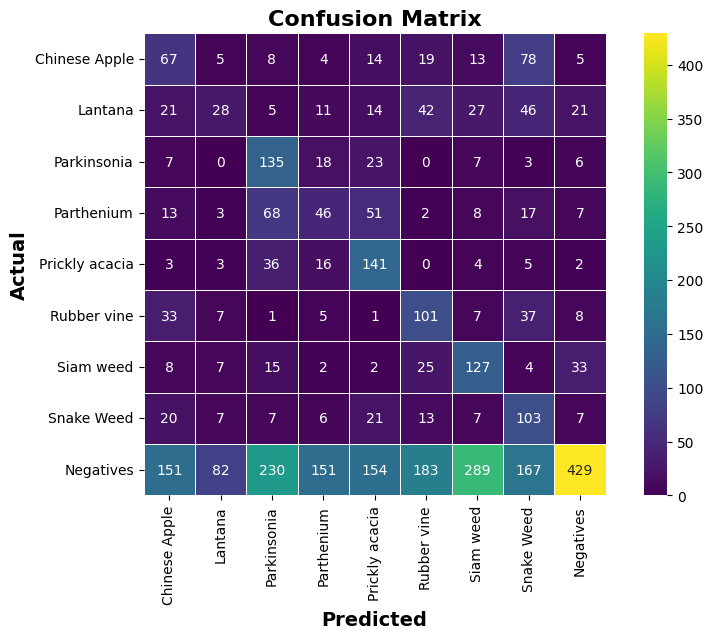


Confusion Matrix:
 [[ 67   5   8   4  14  19  13  78   5]
 [ 21  28   5  11  14  42  27  46  21]
 [  7   0 135  18  23   0   7   3   6]
 [ 13   3  68  46  51   2   8  17   7]
 [  3   3  36  16 141   0   4   5   2]
 [ 33   7   1   5   1 101   7  37   8]
 [  8   7  15   2   2  25 127   4  33]
 [ 20   7   7   6  21  13   7 103   7]
 [151  82 230 151 154 183 289 167 429]]


In [56]:
# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()
print("\nConfusion Matrix:\n", conf_matrix)

# # Normalize the confusion matrix by row (i.e., by the true labels)
# conf_matrix = confusion_matrix(y_test, y_pred)
# conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# plt.figure(figsize=(10, 6))
# sns.heatmap(
#     conf_matrix_normalized, annot=True, fmt=".2%", cmap='viridis', linewidths=0.4, square=True, cbar=True,
#     xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
#                  'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
#     yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
#                  'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
# )

# plt.xlabel('Predicted', fontsize=14, fontweight='bold')
# plt.ylabel('Actual', fontsize=14, fontweight='bold')
# plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')
# plt.yticks(rotation=360)
# plt.show()
# print("\nNormalized Confusion Matrix:\n", conf_matrix_normalized)